# Imports

In [ ]:
# Standard library imports
import os
import logging
import datetime

# Third-party library imports
import h5py
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks

# Hyperparameters

In [ ]:
SAMPLING_RATE = 1000
SECONDS = 5
SIGNAL_LENGTH = SAMPLING_RATE * SECONDS
BATCH_SIZE = 8
TFRECORD_DIR = "./data_preparation/tfrecords-5seconds-singlelead-highres"
TRAINING_BASE_DIR = "./training"


# Helper Functions

In [ ]:
def setup_logger(log_dir, name="training_log"):
    """Sets up a logger that writes to a file in the specified directory."""
    os.makedirs(log_dir, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    log_filename = f"{name}_{timestamp}.log"
    log_filepath = os.path.join(log_dir, log_filename)
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    if not logger.handlers: # This simple check is generally sufficient for distinct logger names
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

        file_handler = logging.FileHandler(log_filepath)
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)

        stream_handler = logging.StreamHandler()
        stream_handler.setFormatter(formatter)
        logger.addHandler(stream_handler)
    return logger

In [ ]:
def _parse_function(example_proto):
    """Parses TFRecord examples and normalizes the signal."""
    feature_description = {
        'signal': tf.io.FixedLenFeature((SIGNAL_LENGTH,), tf.float32),
        'lvef': tf.io.FixedLenFeature((1,), tf.float32),
    }
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    signal = parsed_features['signal']
    lvef = parsed_features['lvef'][0]

    # Normalize the signal *per-signal*
    mean = tf.reduce_mean(signal)
    std = tf.math.reduce_std(signal)
    normalized_signal = (signal - mean) / (std + 1e-8)

    return normalized_signal, lvef

In [ ]:
def create_tf_dataset(tfrecord_files, batch_size=BATCH_SIZE, shuffle_buffer=1000, target_type=None):
    """Creates a tf.data.Dataset from TFRecord files."""
    dataset = tf.data.TFRecordDataset(tfrecord_files)

    def _map_fn(example_proto):
        signal, lvef = _parse_function(example_proto)
        if target_type == 'lvef':
            return signal, lvef
        return signal, lvef

    dataset = dataset.map(_map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=shuffle_buffer)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Model Definition

In [ ]:
def create_cnn_gru_model(input_shape, target_type):
    """
    Creates a CNN-GRU hybrid model for 1-lead ECG analysis, predicting LVEF.

    Args:
        input_shape (tuple): Shape of the input data (time_steps,).
        target_type (str): 'lvef'

    Returns:
        tf.keras.Model: The CNN-GRU model.
    """
    inputs = tf.keras.layers.Input(shape=input_shape)
    expand_dims = tf.expand_dims(inputs, axis=-1)  # Add a channel dimension

    # CNN Layers for Feature Extraction
    conv1 = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same', kernel_regularizer='l2')(expand_dims)
    batchnorm1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling1D(pool_size=2)(batchnorm1)
    dropout1 = layers.Dropout(0.2)(pool1)

    conv2 = layers.Conv1D(filters=128, kernel_size=7, activation='relu', padding='same', kernel_regularizer='l2')(dropout1)
    batchnorm2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling1D(pool_size=2)(batchnorm2)
    dropout2 = layers.Dropout(0.2)(pool2)

    conv3 = layers.Conv1D(filters=256, kernel_size=9, activation='relu', padding='same', kernel_regularizer='l2')(dropout2)
    batchnorm3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling1D(pool_size=2)(batchnorm3)
    dropout3 = layers.Dropout(0.2)(pool3)

    # GRU Layers for Temporal Dependency
    reshaped = layers.Reshape((-1, 256))(dropout3)
    gru1 = layers.GRU(units=128, return_sequences=True, kernel_regularizer='l2')(reshaped)
    dropout4 = layers.Dropout(0.3)(gru1)
    gru2 = layers.GRU(units=128, kernel_regularizer='l2')(dropout4)
    dropout5 = layers.Dropout(0.3)(gru2)

    # Output Layers for LVEF prediction
    dense1 = layers.Dense(64, activation='relu', kernel_regularizer='l2')(dropout5)
    dropout6 = layers.Dropout(0.2)(dense1)
    if target_type == 'lvef':
        output_layer = layers.Dense(1, name='lvef', activation='linear')(dropout6)  # Linear output for LVEF
    else:
        raise ValueError("target_type must be 'lvef'")

    model = models.Model(inputs=inputs, outputs=output_layer)
    return model


# Training

In [ ]:

def main():
    """Main function to orchestrate the training process."""
    # Create a timestamp for the overall training run
    timestamp_run = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    # Define model descriptions
    lvef_model_description = f"lvef_independent_cnn_gru_batch{BATCH_SIZE}_{SECONDS}sec_singlelead_highres"

    # Create model-specific directories for LVEF
    lvef_model_dir = os.path.join(TRAINING_BASE_DIR, f"{timestamp_run}_{lvef_model_description}")
    os.makedirs(lvef_model_dir, exist_ok=True)
    lvef_log_dir = lvef_model_dir
    lvef_checkpoint_path = os.path.join(lvef_model_dir, "checkpoints", "cp-lvef-{epoch:04d}.ckpt")

    # Set up loggers for LVEF
    logger_lvef = setup_logger(lvef_log_dir, "lvef_training_log")

    logger_lvef.info("Starting LVEF training script.")

    # Load patient data
    refTable = pd.read_csv('resources/reference-table.csv')
    all_patients = refTable['Patient_ID'].tolist()

    # Identify patient IDs to exclude (if any)
    excluded_patients = []
    filtered_patients = [pid for pid in all_patients if pid not in excluded_patients]
    logger_lvef.info(f"Number of filtered patients: {len(filtered_patients)}")

    # Split the filtered patients
    train_ids, test_ids = train_test_split(filtered_patients, test_size=0.2, random_state=42)
    logger_lvef.info(f"Number of training IDs: {len(train_ids)}")
    logger_lvef.info(f"Number of testing IDs: {len(test_ids)}")

    # Create TFRecord file lists
    train_tfrecords = [os.path.join(TFRECORD_DIR, f"{pid}_lead_0_window_5s_5s.tfrecord") for pid in train_ids if
                       os.path.exists(os.path.join(TFRECORD_DIR, f"{pid}_lead_0_window_5s_5s.tfrecord"))]
    test_tfrecords = [os.path.join(TFRECORD_DIR, f"{pid}_lead_0_window_5s_5s.tfrecord") for pid in test_ids if
                      os.path.exists(os.path.join(TFRECORD_DIR, f"{pid}_lead_0_window_5s_5s.tfrecord"))]

    logger_lvef.info(f"Number of training TFRecord files: {len(train_tfrecords)}")
    logger_lvef.info(f"Training TFRecord files: {train_tfrecords}")
    logger_lvef.info(f"Number of testing TFRecord files: {len(test_tfrecords)}")
    logger_lvef.info(f"Testing TFRecord files: {test_tfrecords}")

    # Check if enough TFRecords exist
    if not train_tfrecords:
        logger_lvef.error("No training TFRecord files found. Check data preparation and file paths.")
        return
    if not test_tfrecords:
        logger_lvef.error("No testing TFRecord files found. Check data preparation and file paths.")
        return

    input_shape = (SIGNAL_LENGTH,)  # Define input_shape

    # --- LVEF Training ---
    logger_lvef.info("Training for LVEF...")
    logger_lvef.info("Creating LVEF datasets...")
    train_dataset_lvef = create_tf_dataset(train_tfrecords, shuffle_buffer=max(1, len(train_tfrecords)), target_type='lvef')
    test_dataset_lvef = create_tf_dataset(test_tfrecords, batch_size=BATCH_SIZE, shuffle_buffer=1, target_type='lvef')
    logger_lvef.info("LVEF datasets created.")

    model_lvef = create_cnn_gru_model(input_shape, target_type='lvef')
    model_lvef.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model_lvef.summary(print_fn=lambda x: logger_lvef.info(x))  # Log model summary

    # Create checkpoint directory for LVEF
    os.makedirs(os.path.dirname(lvef_checkpoint_path), exist_ok=True)
    cp_callback_lvef = tf.keras.callbacks.ModelCheckpoint(
        filepath=lvef_checkpoint_path,
        verbose=1,
        save_weights_only=True,
        save_freq='epoch'
    )
    early_stopping_lvef = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True,
                                                           verbose=1)
    reduce_lr_lvef = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6,
                                                          verbose=1)
    tensorboard_callback_lvef = callbacks.TensorBoard(log_dir=lvef_model_dir, histogram_freq=1)  # TensorBoard logs
    callbacks_lvef = [cp_callback_lvef, early_stopping_lvef, reduce_lr_lvef, tensorboard_callback_lvef]

    logger_lvef.info("Starting LVEF model training...")
    history_lvef = model_lvef.fit(
        train_dataset_lvef,
        validation_data=test_dataset_lvef,
        epochs=100,
        callbacks=callbacks_lvef,
        verbose=1
    )
    logger_lvef.info("LVEF model training complete.")

    # Save the trained LVEF model
    lvef_saved_model_path = os.path.join(lvef_model_dir, "ecg_model_cnn_gru_lvef.h5")
    model_lvef.save(lvef_saved_model_path)
    logger_lvef.info(f"Trained LVEF model saved to {lvef_saved_model_path}")

    # --- Plotting Individual Graphs ---

    # Save LVEF plots individually
    plt.figure(figsize=(8, 6))  # Create a new figure for the LVEF Loss plot
    plt.plot(history_lvef.history['loss'], label='train_lvef_loss')
    plt.plot(history_lvef.history['val_loss'], label='val_lvef_loss')
    plt.title('LVEF Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    lvef_loss_plot_path = os.path.join(lvef_model_dir, "lvef_training_loss.png")
    plt.savefig(lvef_loss_plot_path)
    logger_lvef.info(f"LVEF training loss plot saved to {lvef_loss_plot_path}")
    plt.close()  # Close the figure to free up memory

    plt.figure(figsize=(8, 6))  # Create a new figure for the LVEF MAE plot
    plt.plot(history_lvef.history['mae'], label='train_lvef_mae')
    plt.plot(history_lvef.history['val_mae'], label='val_lvef_mae')
    plt.title('LVEF MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()
    lvef_mae_plot_path = os.path.join(lvef_model_dir, "lvef_training_mae.png")
    plt.savefig(lvef_mae_plot_path)
    logger_lvef.info(f"LVEF training MAE plot saved to {lvef_mae_plot_path}")
    plt.close()

    logger_lvef.info("LVEF training script finished.")


if __name__ == "__main__":
    logger_root = logging.getLogger() # Get the root logger
    if not logger_root.handlers: # Check if root logger has handlers (e.g., from setup_logger already)
        # If not, set up a basic console handler for initial messages
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    logging.info("Calling main function...")
    main()

2025-06-04 13:34:05,636 - INFO - Calling main function...
2025-06-04 13:34:05,638 - INFO - Starting LVEF training script.
2025-06-04 13:34:05,638 - INFO - Starting LVEF training script.
2025-06-04 13:34:05,642 - INFO - Number of filtered patients: 695
2025-06-04 13:34:05,642 - INFO - Number of filtered patients: 695
2025-06-04 13:34:05,643 - INFO - Number of training IDs: 556
2025-06-04 13:34:05,643 - INFO - Number of training IDs: 556
2025-06-04 13:34:05,643 - INFO - Number of testing IDs: 139
2025-06-04 13:34:05,643 - INFO - Number of testing IDs: 139
2025-06-04 13:34:05,658 - INFO - Number of training TFRecord files: 362
2025-06-04 13:34:05,658 - INFO - Number of training TFRecord files: 362
2025-06-04 13:34:05,659 - INFO - Training TFRecord files: ['./data_preparation/tfrecords-5seconds-singlelead-highres\\P0177_lead_0_window_5s_5s.tfrecord', './data_preparation/tfrecords-5seconds-singlelead-highres\\P0128_lead_0_window_5s_5s.tfrecord', './data_preparation/tfrecords-5seconds-single

Epoch 1/100
     91/Unknown - 7s 56ms/step - loss: 589.2769 - mae: 19.2456
Epoch 1: saving model to ./training\20250604_133405_lvef_independent_cnn_gru_batch4_5sec_singlelead_highres\checkpoints\cp-lvef-0001.ckpt
91/91 [==============================] - 9s 73ms/step - loss: 589.2769 - mae: 19.2456 - val_loss: 210.7576 - val_mae: 11.0441 - lr: 0.0010
Epoch 2/100
90/91 [============================>.] - ETA: 0s - loss: 212.1593 - mae: 11.0631
Epoch 2: saving model to ./training\20250604_133405_lvef_independent_cnn_gru_batch4_5sec_singlelead_highres\checkpoints\cp-lvef-0002.ckpt
91/91 [==============================] - 6s 66ms/step - loss: 211.2685 - mae: 11.0359 - val_loss: 217.9395 - val_mae: 11.6813 - lr: 0.0010
Epoch 3/100
90/91 [============================>.] - ETA: 0s - loss: 221.7273 - mae: 11.5540
Epoch 3: saving model to ./training\20250604_133405_lvef_independent_cnn_gru_batch4_5sec_singlelead_highres\checkpoints\cp-lvef-0003.ckpt
91/91 [==============================] - 6s 66m

2025-06-04 13:41:09,418 - INFO - LVEF model training complete.
2025-06-04 13:41:09,418 - INFO - LVEF model training complete.
2025-06-04 13:41:09,464 - INFO - Trained LVEF model saved to ./training\20250604_133405_lvef_independent_cnn_gru_batch4_5sec_singlelead_highres\ecg_model_cnn_gru_lvef.h5
2025-06-04 13:41:09,464 - INFO - Trained LVEF model saved to ./training\20250604_133405_lvef_independent_cnn_gru_batch4_5sec_singlelead_highres\ecg_model_cnn_gru_lvef.h5
2025-06-04 13:41:09,530 - INFO - LVEF training loss plot saved to ./training\20250604_133405_lvef_independent_cnn_gru_batch4_5sec_singlelead_highres\lvef_training_loss.png
2025-06-04 13:41:09,530 - INFO - LVEF training loss plot saved to ./training\20250604_133405_lvef_independent_cnn_gru_batch4_5sec_singlelead_highres\lvef_training_loss.png
2025-06-04 13:41:09,589 - INFO - LVEF training MAE plot saved to ./training\20250604_133405_lvef_independent_cnn_gru_batch4_5sec_singlelead_highres\lvef_training_mae.png
2025-06-04 13:41:09,

In [ ]:
import os
import logging
import datetime
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

SAMPLING_RATE = 1000
SECONDS = 5
SIGNAL_LENGTH = SAMPLING_RATE * SECONDS
BATCH_SIZE = 8
TFRECORD_DIR = "./data_preparation/tfrecords-5seconds-singlelead-highres"
TRAINING_BASE_DIR = "./training"


def setup_logger(log_dir, name="training_log"):
    """Sets up a logger that writes to a file in the specified directory."""
    os.makedirs(log_dir, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    log_filename = f"{name}_{timestamp}.log"
    log_filepath = os.path.join(log_dir, log_filename)
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    if not logger.handlers:
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

        file_handler = logging.FileHandler(log_filepath)
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)

        stream_handler = logging.StreamHandler()
        stream_handler.setFormatter(formatter)
        logger.addHandler(stream_handler)
    return logger


def _parse_function(example_proto):
    """Parses TFRecord examples and normalizes the signal."""
    feature_description = {
        'signal': tf.io.FixedLenFeature((SIGNAL_LENGTH,), tf.float32),
        'lvef': tf.io.FixedLenFeature((1,), tf.float32),
    }
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    signal = parsed_features['signal']
    lvef = parsed_features['lvef'][0]

    # Normalize the signal *per-signal*
    mean = tf.reduce_mean(signal)
    std = tf.math.reduce_std(signal)
    normalized_signal = (signal - mean) / (std + 1e-8)

    return normalized_signal, lvef


def create_tf_dataset(tfrecord_files, batch_size=BATCH_SIZE, shuffle_buffer=1000, target_type=None):
    """Creates a tf.data.Dataset from TFRecord files."""
    dataset = tf.data.TFRecordDataset(tfrecord_files)

    def _map_fn(example_proto):
        signal, lvef = _parse_function(example_proto)
        if target_type == 'lvef':
            return signal, lvef
        return signal, lvef # This line will never be reached if target_type is not 'lvef' based on create_cnn_gru_model
                             # but it's harmless.

    dataset = dataset.map(_map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=shuffle_buffer)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


def create_cnn_lstm_model(input_shape, target_type): # Renamed function for clarity
    """
    Creates a CNN-LSTM hybrid model for 1-lead ECG analysis, predicting LVEF.

    Args:
        input_shape (tuple): Shape of the input data (time_steps,).
        target_type (str): 'lvef'

    Returns:
        tf.keras.Model: The CNN-LSTM model.
    """
    inputs = tf.keras.layers.Input(shape=input_shape)
    expand_dims = tf.expand_dims(inputs, axis=-1)  # Add a channel dimension

    # Leaky ReLU activation function
    leaky_relu = layers.LeakyReLU(alpha=0.1) # You can adjust alpha (typically between 0.01 and 0.3)

    # CNN Layers for Feature Extraction
    conv1 = layers.Conv1D(filters=64, kernel_size=5, activation=leaky_relu, padding='same', kernel_regularizer='l2')(expand_dims)
    batchnorm1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling1D(pool_size=2)(batchnorm1)
    dropout1 = layers.Dropout(0.2)(pool1)

    conv2 = layers.Conv1D(filters=128, kernel_size=7, activation=leaky_relu, padding='same', kernel_regularizer='l2')(dropout1)
    batchnorm2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling1D(pool_size=2)(batchnorm2)
    dropout2 = layers.Dropout(0.2)(pool2)

    conv3 = layers.Conv1D(filters=256, kernel_size=9, activation=leaky_relu, padding='same', kernel_regularizer='l2')(dropout2)
    batchnorm3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling1D(pool_size=2)(batchnorm3)
    dropout3 = layers.Dropout(0.2)(pool3)

    # LSTM Layers for Temporal Dependency
    reshaped = layers.Reshape((-1, 256))(dropout3)
    lstm1 = layers.LSTM(units=128, return_sequences=True, kernel_regularizer='l2')(reshaped)
    dropout4 = layers.Dropout(0.3)(lstm1)
    lstm2 = layers.LSTM(units=128, kernel_regularizer='l2')(dropout4)
    dropout5 = layers.Dropout(0.3)(lstm2)

    # Output Layers for LVEF prediction
    dense1 = layers.Dense(64, activation=leaky_relu, kernel_regularizer='l2')(dropout5)
    dropout6 = layers.Dropout(0.2)(dense1)
    if target_type == 'lvef':
        output_layer = layers.Dense(1, name='lvef', activation='linear')(dropout6)  # Linear output for LVEF
    else:
        raise ValueError("target_type must be 'lvef'")

    model = models.Model(inputs=inputs, outputs=output_layer)
    return model


def main():
    """Main function to orchestrate the training process."""
    # Create a timestamp for the overall training run
    timestamp_run = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    # Define model descriptions
    lvef_model_description = f"lvef_independent_cnn_lstm_batch{BATCH_SIZE}_{SECONDS}sec_singlelead_highres" # Updated description for LSTM

    # Create model-specific directories for LVEF
    lvef_model_dir = os.path.join(TRAINING_BASE_DIR, f"{timestamp_run}_{lvef_model_description}")
    os.makedirs(lvef_model_dir, exist_ok=True)
    lvef_log_dir = lvef_model_dir
    lvef_checkpoint_path = os.path.join(lvef_model_dir, "checkpoints", "cp-lvef-{epoch:04d}.ckpt")

    # Set up loggers for LVEF
    logger_lvef = setup_logger(lvef_log_dir, "lvef_training_log")

    logger_lvef.info("Starting LVEF training script.")
    # Optimized: Removed print statement, logger handles console output
    # print("Starting main function...")

    # Load patient data
    refTable = pd.read_csv('resources/reference-table.csv')
    all_patients = refTable['Patient_ID'].tolist()

    # Identify patient IDs to exclude (if any)
    excluded_patients = []
    filtered_patients = [pid for pid in all_patients if pid not in excluded_patients]
    logger_lvef.info(f"Number of filtered patients: {len(filtered_patients)}")

    # Split the filtered patients
    train_ids, test_ids = train_test_split(filtered_patients, test_size=0.2, random_state=42)
    logger_lvef.info(f"Number of training IDs: {len(train_ids)}")
    logger_lvef.info(f"Number of testing IDs: {len(test_ids)}")

    # Create TFRecord file lists
    train_tfrecords = [os.path.join(TFRECORD_DIR, f"{pid}_lead_0_window_5s_5s.tfrecord") for pid in train_ids if
                       os.path.exists(os.path.join(TFRECORD_DIR, f"{pid}_lead_0_window_5s_5s.tfrecord"))]
    test_tfrecords = [os.path.join(TFRECORD_DIR, f"{pid}_lead_0_window_5s_5s.tfrecord") for pid in test_ids if
                      os.path.exists(os.path.join(TFRECORD_DIR, f"{pid}_lead_0_window_5s_5s.tfrecord"))]

    logger_lvef.info(f"Number of training TFRecord files: {len(train_tfrecords)}")
    logger_lvef.info(f"Training TFRecord files: {train_tfrecords}")
    logger_lvef.info(f"Number of testing TFRecord files: {len(test_tfrecords)}")
    logger_lvef.info(f"Testing TFRecord files: {test_tfrecords}")

    # Check if enough TFRecords exist
    if not train_tfrecords:
        logger_lvef.error("No training TFRecord files found. Check data preparation and file paths.")
        return
    if not test_tfrecords:
        logger_lvef.error("No testing TFRecord files found. Check data preparation and file paths.")
        return

    input_shape = (SIGNAL_LENGTH,)  # Define input_shape

    # --- LVEF Training ---
    logger_lvef.info("Training for LVEF...")
    logger_lvef.info("Creating LVEF datasets...")
    train_dataset_lvef = create_tf_dataset(train_tfrecords, shuffle_buffer=max(1, len(train_tfrecords)), target_type='lvef')
    test_dataset_lvef = create_tf_dataset(test_tfrecords, batch_size=BATCH_SIZE, shuffle_buffer=1, target_type='lvef')
    logger_lvef.info("LVEF datasets created.")

    model_lvef = create_cnn_lstm_model(input_shape, target_type='lvef') # Changed to create_cnn_lstm_model
    model_lvef.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model_lvef.summary(print_fn=lambda x: logger_lvef.info(x))  # Log model summary

    # Create checkpoint directory for LVEF
    os.makedirs(os.path.dirname(lvef_checkpoint_path), exist_ok=True)
    cp_callback_lvef = tf.keras.callbacks.ModelCheckpoint(
        filepath=lvef_checkpoint_path,
        verbose=1,
        save_weights_only=True,
        save_freq='epoch'
    )
    early_stopping_lvef = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True,
                                                           verbose=1)
    reduce_lr_lvef = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6,
                                                          verbose=1)
    tensorboard_callback_lvef = callbacks.TensorBoard(log_dir=lvef_model_dir, histogram_freq=1)  # TensorBoard logs
    callbacks_lvef = [cp_callback_lvef, early_stopping_lvef, reduce_lr_lvef, tensorboard_callback_lvef]

    logger_lvef.info("Starting LVEF model training...")
    # Optimized: Removed print statement
    # print("Starting LVEF model training...")
    history_lvef = model_lvef.fit(
        train_dataset_lvef,
        validation_data=test_dataset_lvef,
        epochs=100,
        callbacks=callbacks_lvef,
        verbose=1
    )
    logger_lvef.info("LVEF model training complete.")

    # Save the trained LVEF model
    lvef_saved_model_path = os.path.join(lvef_model_dir, "ecg_model_cnn_lstm_lvef.h5") # Updated saved model name
    model_lvef.save(lvef_saved_model_path)
    logger_lvef.info(f"Trained LVEF model saved to {lvef_saved_model_path}")

    # --- Plotting Individual Graphs ---

    # Save LVEF plots individually
    plt.figure(figsize=(8, 6))  # Create a new figure for the LVEF Loss plot
    plt.plot(history_lvef.history['loss'], label='train_lvef_loss')
    plt.plot(history_lvef.history['val_loss'], label='val_lvef_loss')
    plt.title('LVEF Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    lvef_loss_plot_path = os.path.join(lvef_model_dir, "lvef_training_loss.png")
    plt.savefig(lvef_loss_plot_path)
    logger_lvef.info(f"LVEF training loss plot saved to {lvef_loss_plot_path}")
    plt.close()  # Close the figure to free up memory

    plt.figure(figsize=(8, 6))  # Create a new figure for the LVEF MAE plot
    plt.plot(history_lvef.history['mae'], label='train_lvef_mae')
    plt.plot(history_lvef.history['val_mae'], label='val_lvef_mae')
    plt.title('LVEF MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()
    lvef_mae_plot_path = os.path.join(lvef_model_dir, "lvef_training_mae.png")
    plt.savefig(lvef_mae_plot_path)
    logger_lvef.info(f"LVEF training MAE plot saved to {lvef_mae_plot_path}")
    plt.close()

    logger_lvef.info("LVEF training script finished.")


if __name__ == "__main__":
    logger_root = logging.getLogger() # Get the root logger
    if not logger_root.handlers: # Check if root logger has handlers (e.g., from setup_logger already)
        # If not, set up a basic console handler for initial messages
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    logging.info("Calling main function...")
    main()

2025-06-03 20:53:09,009 - INFO - Calling main function...
2025-06-03 20:53:09,010 - INFO - Starting LVEF training script.
2025-06-03 20:53:09,010 - INFO - Starting LVEF training script.
2025-06-03 20:53:09,149 - INFO - Number of filtered patients: 695
2025-06-03 20:53:09,149 - INFO - Number of filtered patients: 695
2025-06-03 20:53:09,154 - INFO - Number of training IDs: 556
2025-06-03 20:53:09,154 - INFO - Number of training IDs: 556
2025-06-03 20:53:09,156 - INFO - Number of testing IDs: 139
2025-06-03 20:53:09,156 - INFO - Number of testing IDs: 139
2025-06-03 20:53:09,169 - INFO - Number of training TFRecord files: 362
2025-06-03 20:53:09,169 - INFO - Number of training TFRecord files: 362
2025-06-03 20:53:09,171 - INFO - Training TFRecord files: ['./data_preparation/tfrecords-5seconds-singlelead-highres\\P0177_lead_0_window_5s_5s.tfrecord', './data_preparation/tfrecords-5seconds-singlelead-highres\\P0128_lead_0_window_5s_5s.tfrecord', './data_preparation/tfrecords-5seconds-single

Epoch 1/100
     46/Unknown - 5s 58ms/step - loss: 735.3909 - mae: 22.3011
Epoch 1: saving model to ./training\20250603_205309_lvef_independent_cnn_lstm_batch8_5sec_singlelead_highres\checkpoints\cp-lvef-0001.ckpt
46/46 [==============================] - 6s 88ms/step - loss: 735.3909 - mae: 22.3011 - val_loss: 216.8985 - val_mae: 11.5553 - lr: 0.0010
Epoch 2/100
46/46 [==============================] - ETA: 0s - loss: 218.2269 - mae: 11.3306
Epoch 2: saving model to ./training\20250603_205309_lvef_independent_cnn_lstm_batch8_5sec_singlelead_highres\checkpoints\cp-lvef-0002.ckpt
46/46 [==============================] - 4s 76ms/step - loss: 218.2269 - mae: 11.3306 - val_loss: 210.6359 - val_mae: 11.0234 - lr: 0.0010
Epoch 3/100
46/46 [==============================] - ETA: 0s - loss: 208.7956 - mae: 11.2852
Epoch 3: saving model to ./training\20250603_205309_lvef_independent_cnn_lstm_batch8_5sec_singlelead_highres\checkpoints\cp-lvef-0003.ckpt
46/46 [==============================] - 4s 

2025-06-03 20:57:31,681 - INFO - LVEF model training complete.
2025-06-03 20:57:31,681 - INFO - LVEF model training complete.
2025-06-03 20:57:31,796 - INFO - Trained LVEF model saved to ./training\20250603_205309_lvef_independent_cnn_lstm_batch8_5sec_singlelead_highres\ecg_model_cnn_lstm_lvef.h5
2025-06-03 20:57:31,796 - INFO - Trained LVEF model saved to ./training\20250603_205309_lvef_independent_cnn_lstm_batch8_5sec_singlelead_highres\ecg_model_cnn_lstm_lvef.h5
2025-06-03 20:57:31,890 - INFO - LVEF training loss plot saved to ./training\20250603_205309_lvef_independent_cnn_lstm_batch8_5sec_singlelead_highres\lvef_training_loss.png
2025-06-03 20:57:31,890 - INFO - LVEF training loss plot saved to ./training\20250603_205309_lvef_independent_cnn_lstm_batch8_5sec_singlelead_highres\lvef_training_loss.png
2025-06-03 20:57:31,951 - INFO - LVEF training MAE plot saved to ./training\20250603_205309_lvef_independent_cnn_lstm_batch8_5sec_singlelead_highres\lvef_training_mae.png
2025-06-03 20

Inference results will be saved to: ./inference_results\inference_run_20250604_153154
Number of testing IDs: 139
Successfully loaded LVEF model from: ./training\20250604_151603_lvef_independent_cnn_gru_batch8_5sec_singlelead_highres\ecg_model_cnn_gru_lvef.h5


Predicting: 100%|██████████| 95/95 [00:08<00:00, 11.45it/s]



Inference Results Summary:
LVEF MAE: 10.6791, MSE: 171.3295, Correlation: 0.3930
Detailed inference results saved to: ./inference_results\inference_run_20250604_153154\inference_results_test_set.csv
Scatter plot saved to: ./inference_results\inference_run_20250604_153154\lvef_prediction_scatter_plot_test_set.png


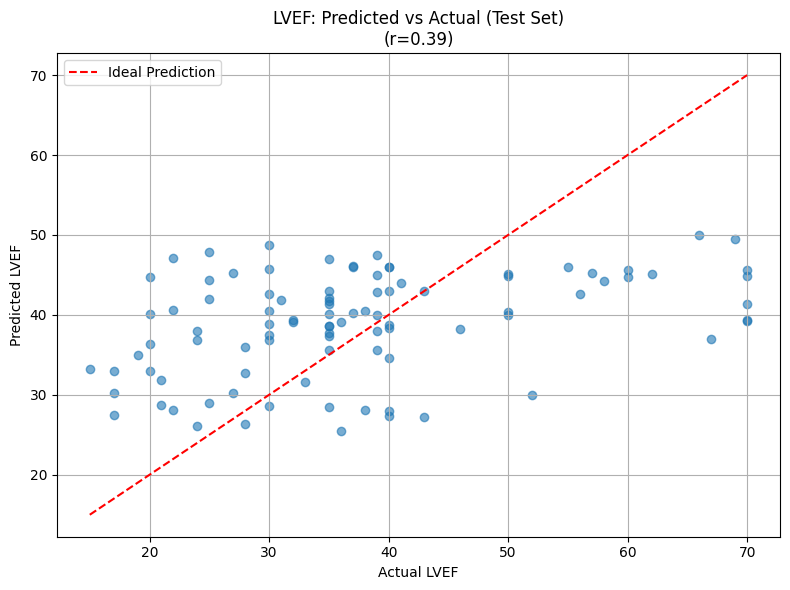

In [23]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split # Import train_test_split

# Configuration
SAMPLING_RATE = 1000
SECONDS = 5
SIGNAL_LENGTH = SAMPLING_RATE * SECONDS
TFRECORD_DIR = "./data_preparation/tfrecords-5seconds-singlelead-highres"

# Base directory for loading trained models and saving inference results
TRAINING_BASE_DIR = "./training"
INFERENCE_OUTPUT_DIR = "./inference_results"


# Function to load a single TFRecord file and extract the signal
def load_single_tfrecord(tfrecord_file):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)

    def _parse_function(example_proto):
        feature_description = {
            'signal': tf.io.FixedLenFeature((SIGNAL_LENGTH,), tf.float32),
            'lvef': tf.io.FixedLenFeature((1,), tf.float32),
        }
        parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        signal = parsed_features['signal']
        lvef = parsed_features['lvef'][0]

        # Normalize the signal per-signal, consistent with training
        mean = tf.reduce_mean(signal)
        std = tf.math.reduce_std(signal)
        normalized_signal = (signal - mean) / (std + 1e-8)

        return normalized_signal, lvef

    parsed_dataset = raw_dataset.map(_parse_function)
    # Take the first (and should be only) example
    for signal, lvef in parsed_dataset.take(1):
        return signal.numpy(), lvef.numpy()


def perform_inference(tfrecord_files, model_lvef):
    """
    Performs inference on a set of TFRecord files using the provided LVEF model.

    Args:
        tfrecord_files (list): A list of paths to the TFRecord files.
        model_lvef (tf.keras.Model): The trained model for LVEF prediction.

    Returns:
        pandas.DataFrame: A DataFrame containing the Patient IDs, predicted LVEF, and actual LVEF.
    """
    predictions = {}
    actual_lvefs = {}

    for tfrecord_file in tqdm(tfrecord_files, desc="Predicting"):
        patient_id = os.path.splitext(os.path.basename(tfrecord_file))[0].split('_')[0]
        signal, actual_lvef = load_single_tfrecord(tfrecord_file)
        signal = np.expand_dims(signal, axis=0)

        predicted_lvef = model_lvef.predict(signal, verbose=0)[0][0]
        predictions[patient_id] = {'LVEF': predicted_lvef}
        actual_lvefs[patient_id] = actual_lvef

    results_df = pd.DataFrame.from_dict(
        {
            'Patient_ID': list(predictions.keys()),
            'Predicted_LVEF': [predictions[pid]['LVEF'] for pid in predictions],
            'Actual_LVEF': [actual_lvefs[pid] for pid in predictions.keys()],
        }
    )
    return results_df


def find_latest_model_path(base_dir, model_target_type):
    """
    Finds the path to the latest trained model directory for a given target type.
    Assumes directories are named with a timestamp prefix (e.g., 'YYYYMMDD_HHMMSS_lvef_model_description').
    """
    latest_dir = None
    latest_timestamp = None

    for entry in os.listdir(base_dir):
        if model_target_type in entry and os.path.isdir(os.path.join(base_dir, entry)):
            try:
                timestamp_str = entry.split('_')[0] + '_' + entry.split('_')[1]
                current_timestamp = datetime.datetime.strptime(timestamp_str, "%Y%m%d_%H%M%S")
                if latest_timestamp is None or current_timestamp > latest_timestamp:
                    latest_timestamp = current_timestamp
                    latest_dir = entry
            except (ValueError, IndexError):
                continue

    if latest_dir:
        return os.path.join(base_dir, latest_dir)
    return None


def main():
    """Main function to load models, perform inference, and calculate Pearson correlation."""
    # Create a timestamped directory for this inference run
    timestamp_inference = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    current_inference_output_dir = os.path.join(INFERENCE_OUTPUT_DIR, f"inference_run_{timestamp_inference}")
    os.makedirs(current_inference_output_dir, exist_ok=True)
    print(f"Inference results will be saved to: {current_inference_output_dir}")

    try:
        _ = BATCH_SIZE
    except NameError:
        print("WARNING: BATCH_SIZE not defined. Proceeding without it in model description string.")
        lvef_model_description_part = f"lvef_independent_cnn_gru_{SECONDS}sec_singlelead_highres"
    else:
        lvef_model_description_part = f"lvef_independent_cnn_gru_batch{BATCH_SIZE}_{SECONDS}sec_singlelead_highres"


    lvef_model_base_path = find_latest_model_path(TRAINING_BASE_DIR, lvef_model_description_part)

    if not lvef_model_base_path:
        print(f"Error: Could not find the latest trained LVEF model directory in {TRAINING_BASE_DIR}")
        return

    lvef_model_path = os.path.join(lvef_model_base_path, "ecg_model_cnn_gru_lvef.h5")

    # --- Replicate the train-test split logic ---
    # Load patient data
    refTable = pd.read_csv('resources/reference-table.csv')
    all_patients = refTable['Patient_ID'].tolist()

    excluded_patients = [] # Assuming no patients were excluded in training, or replicate exclusion if any
    filtered_patients = [pid for pid in all_patients if pid not in excluded_patients]

    # Replicate the exact split used during training (assuming random_state=42)
    _, test_ids = train_test_split(filtered_patients, test_size=0.2, random_state=42)
    print(f"Number of testing IDs: {len(test_ids)}")

    # Create TFRecord file list specifically for test_ids
    inference_tfrecords = [
        os.path.join(TFRECORD_DIR, f"{pid}_lead_0_window_5s_5s.tfrecord")
        for pid in test_ids
        if os.path.exists(os.path.join(TFRECORD_DIR, f"{pid}_lead_0_window_5s_5s.tfrecord"))
    ]

    if not inference_tfrecords:
        print(f"No TFRecord files found for the test set IDs in {TFRECORD_DIR}. Please check your data directory and test IDs.")
        return

    # Load the trained model
    try:
        model_lvef = tf.keras.models.load_model(lvef_model_path)
        print(f"Successfully loaded LVEF model from: {lvef_model_path}")
    except Exception as e:
        print(f"Error loading model. Make sure the model exists at the specified path: {e}")
        print(f"Attempted LVEF model path: {lvef_model_path}")
        return

    # Perform inference
    results_df = perform_inference(inference_tfrecords, model_lvef)

    # Calculate and print MAE and MSE for LVEF
    mae_lvef = np.mean(np.abs(results_df['Predicted_LVEF'] - results_df['Actual_LVEF']))
    mse_lvef = np.mean((results_df['Predicted_LVEF'] - results_df['Actual_LVEF'])**2)

    # Calculate Pearson Correlation Coefficient
    lvef_correlation, _ = pearsonr(results_df['Predicted_LVEF'], results_df['Actual_LVEF'])

    # Print results
    print("\nInference Results Summary:")
    print(f"LVEF MAE: {mae_lvef:.4f}, MSE: {mse_lvef:.4f}, Correlation: {lvef_correlation:.4f}")

    # Save the detailed results to a CSV file.
    results_csv_path = os.path.join(current_inference_output_dir, "inference_results_test_set.csv")
    results_df.to_csv(results_csv_path, index=False)
    print(f"Detailed inference results saved to: {results_csv_path}")

    # Create scatter plots
    plt.figure(figsize=(8, 6))

    plt.scatter(results_df['Actual_LVEF'], results_df['Predicted_LVEF'], alpha=0.6)
    plt.title(f"LVEF: Predicted vs Actual (Test Set)\n(r={lvef_correlation:.2f})")
    plt.xlabel("Actual LVEF")
    plt.ylabel("Predicted LVEF")
    plt.grid(True)
    plt.plot([min(results_df['Actual_LVEF']), max(results_df['Actual_LVEF'])],
             [min(results_df['Actual_LVEF']), max(results_df['Actual_LVEF'])],
             '--r', label='Ideal Prediction')
    plt.legend()

    plt.tight_layout()
    plots_path = os.path.join(current_inference_output_dir, "lvef_prediction_scatter_plot_test_set.png")
    plt.savefig(plots_path)
    print(f"Scatter plot saved to: {plots_path}")
    plt.show()


if __name__ == "__main__":
    main()

Inference results will be saved to: ./inference_results\inference_run_20250604_153006
Number of TFRecord files found for inference: 457
Successfully loaded LVEF model from: ./training\20250604_151603_lvef_independent_cnn_gru_batch8_5sec_singlelead_highres\ecg_model_cnn_gru_lvef.h5


Predicting: 100%|██████████| 457/457 [00:37<00:00, 12.12it/s]


Inference Results Summary (All Signals):
LVEF MAE: 8.5736, MSE: 119.1401, Correlation: 0.6012
Detailed inference results saved to: ./inference_results\inference_run_20250604_153006\inference_results_all_signals.csv
Scatter plot saved to: ./inference_results\inference_run_20250604_153006\lvef_prediction_scatter_plot_all_signals.png


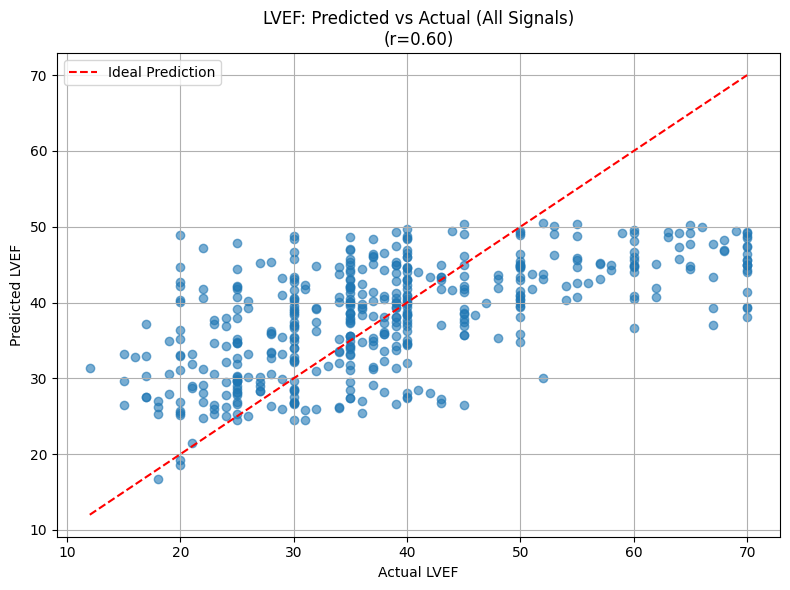

In [22]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import datetime
# No need to import train_test_split if we are not splitting for inference

# Configuration
SAMPLING_RATE = 1000
SECONDS = 5
SIGNAL_LENGTH = SAMPLING_RATE * SECONDS
TFRECORD_DIR = "./data_preparation/tfrecords-5seconds-singlelead-highres"

# Base directory for loading trained models and saving inference results
TRAINING_BASE_DIR = "./training"
INFERENCE_OUTPUT_DIR = "./inference_results"


# Function to load a single TFRecord file and extract the signal
def load_single_tfrecord(tfrecord_file):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)

    def _parse_function(example_proto):
        feature_description = {
            'signal': tf.io.FixedLenFeature((SIGNAL_LENGTH,), tf.float32),
            'lvef': tf.io.FixedLenFeature((1,), tf.float32),
        }
        parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        signal = parsed_features['signal']
        lvef = parsed_features['lvef'][0]

        # Normalize the signal per-signal, consistent with training
        mean = tf.reduce_mean(signal)
        std = tf.math.reduce_std(signal)
        normalized_signal = (signal - mean) / (std + 1e-8)

        return normalized_signal, lvef

    parsed_dataset = raw_dataset.map(_parse_function)
    # Take the first (and should be only) example
    for signal, lvef in parsed_dataset.take(1):
        return signal.numpy(), lvef.numpy()


def perform_inference(tfrecord_files, model_lvef):
    """
    Performs inference on a set of TFRecord files using the provided LVEF model.

    Args:
        tfrecord_files (list): A list of paths to the TFRecord files.
        model_lvef (tf.keras.Model): The trained model for LVEF prediction.

    Returns:
        pandas.DataFrame: A DataFrame containing the Patient IDs, predicted LVEF, and actual LVEF.
    """
    predictions = {}
    actual_lvefs = {}

    for tfrecord_file in tqdm(tfrecord_files, desc="Predicting"):
        patient_id = os.path.splitext(os.path.basename(tfrecord_file))[0].split('_')[0]
        signal, actual_lvef = load_single_tfrecord(tfrecord_file)
        signal = np.expand_dims(signal, axis=0)

        predicted_lvef = model_lvef.predict(signal, verbose=0)[0][0]
        predictions[patient_id] = {'LVEF': predicted_lvef}
        actual_lvefs[patient_id] = actual_lvef

    results_df = pd.DataFrame.from_dict(
        {
            'Patient_ID': list(predictions.keys()),
            'Predicted_LVEF': [predictions[pid]['LVEF'] for pid in predictions],
            'Actual_LVEF': [actual_lvefs[pid] for pid in predictions.keys()],
        }
    )
    return results_df


def find_latest_model_path(base_dir, model_target_type):
    """
    Finds the path to the latest trained model directory for a given target type.
    Assumes directories are named with a timestamp prefix (e.g., 'YYYYMMDD_HHMMSS_lvef_model_description').
    """
    latest_dir = None
    latest_timestamp = None

    for entry in os.listdir(base_dir):
        if model_target_type in entry and os.path.isdir(os.path.join(base_dir, entry)):
            try:
                timestamp_str = entry.split('_')[0] + '_' + entry.split('_')[1]
                current_timestamp = datetime.datetime.strptime(timestamp_str, "%Y%m%d_%H%M%S")
                if latest_timestamp is None or current_timestamp > latest_timestamp:
                    latest_timestamp = current_timestamp
                    latest_dir = entry
            except (ValueError, IndexError):
                continue

    if latest_dir:
        return os.path.join(base_dir, latest_dir)
    return None


def main():
    """Main function to load models, perform inference, and calculate Pearson correlation."""
    # Create a timestamped directory for this inference run
    timestamp_inference = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    current_inference_output_dir = os.path.join(INFERENCE_OUTPUT_DIR, f"inference_run_{timestamp_inference}")
    os.makedirs(current_inference_output_dir, exist_ok=True)
    print(f"Inference results will be saved to: {current_inference_output_dir}")

    try:
        _ = BATCH_SIZE
    except NameError:
        print("WARNING: BATCH_SIZE not defined. Proceeding without it in model description string.")
        lvef_model_description_part = f"lvef_independent_cnn_gru_{SECONDS}sec_singlelead_highres"
    else:
        lvef_model_description_part = f"lvef_independent_cnn_gru_batch{BATCH_SIZE}_{SECONDS}sec_singlelead_highres"


    lvef_model_base_path = find_latest_model_path(TRAINING_BASE_DIR, lvef_model_description_part)

    if not lvef_model_base_path:
        print(f"Error: Could not find the latest trained LVEF model directory in {TRAINING_BASE_DIR}")
        return

    lvef_model_path = os.path.join(lvef_model_base_path, "ecg_model_cnn_gru_lvef.h5")

    # --- Load ALL TFRecord files for inference ---
    # List all TFRecord files in the directory
    all_tfrecords = [
        os.path.join(TFRECORD_DIR, f)
        for f in os.listdir(TFRECORD_DIR)
        if f.endswith(".tfrecord") and "_lead_0_window_5s_5s.tfrecord" in f # Ensure we only get the relevant files
    ]

    if not all_tfrecords:
        print(f"No TFRecord files found in {TFRECORD_DIR}. Please check your data directory.")
        return
    
    print(f"Number of TFRecord files found for inference: {len(all_tfrecords)}")


    # Load the trained model
    try:
        # Custom objects might be needed if you used custom layers or activations (e.g., Leaky ReLU)
        # model_lvef = tf.keras.models.load_model(lvef_model_path, custom_objects={'LeakyReLU': tf.keras.layers.LeakyReLU})
        model_lvef = tf.keras.models.load_model(lvef_model_path)
        print(f"Successfully loaded LVEF model from: {lvef_model_path}")
    except Exception as e:
        print(f"Error loading model. Make sure the model exists at the specified path and handle custom objects if any: {e}")
        print(f"Attempted LVEF model path: {lvef_model_path}")
        return

    # Perform inference on ALL signals
    results_df = perform_inference(all_tfrecords, model_lvef)

    # Calculate and print MAE and MSE for LVEF
    mae_lvef = np.mean(np.abs(results_df['Predicted_LVEF'] - results_df['Actual_LVEF']))
    mse_lvef = np.mean((results_df['Predicted_LVEF'] - results_df['Actual_LVEF'])**2)

    # Calculate Pearson Correlation Coefficient
    lvef_correlation, _ = pearsonr(results_df['Predicted_LVEF'], results_df['Actual_LVEF'])

    # Print results
    print("\nInference Results Summary (All Signals):")
    print(f"LVEF MAE: {mae_lvef:.4f}, MSE: {mse_lvef:.4f}, Correlation: {lvef_correlation:.4f}")

    # Save the detailed results to a CSV file.
    results_csv_path = os.path.join(current_inference_output_dir, "inference_results_all_signals.csv")
    results_df.to_csv(results_csv_path, index=False)
    print(f"Detailed inference results saved to: {results_csv_path}")

    # Create scatter plots
    plt.figure(figsize=(8, 6))

    plt.scatter(results_df['Actual_LVEF'], results_df['Predicted_LVEF'], alpha=0.6)
    plt.title(f"LVEF: Predicted vs Actual (All Signals)\n(r={lvef_correlation:.2f})")
    plt.xlabel("Actual LVEF")
    plt.ylabel("Predicted LVEF")
    plt.grid(True)
    # Add a line for ideal prediction (y=x)
    min_val = min(results_df['Actual_LVEF'].min(), results_df['Predicted_LVEF'].min())
    max_val = max(results_df['Actual_LVEF'].max(), results_df['Predicted_LVEF'].max())
    plt.plot([min_val, max_val], [min_val, max_val], '--r', label='Ideal Prediction')
    plt.legend()

    plt.tight_layout()
    plots_path = os.path.join(current_inference_output_dir, "lvef_prediction_scatter_plot_all_signals.png")
    plt.savefig(plots_path)
    print(f"Scatter plot saved to: {plots_path}")
    plt.show()


if __name__ == "__main__":
    main()

Inference results will be saved to: ./inference_results\inference_run_20250605_015506_lstm
Number of TFRecord files found for inference: 457
Successfully loaded LVEF model (lstm) from: ./training\20250603_205309_lvef_independent_cnn_lstm_batch8_5sec_singlelead_highres\ecg_model_cnn_lstm_lvef.h5


Predicting: 100%|██████████| 457/457 [00:36<00:00, 12.47it/s]



Inference Results Summary (All Signals):
LVEF MAE: 8.6907, MSE: 128.5320, Correlation: 0.5651
Detailed inference results saved to: ./inference_results\inference_run_20250605_015506_lstm\inference_results_all_signals.csv
Scatter plot saved to: ./inference_results\inference_run_20250605_015506_lstm\lvef_prediction_scatter_plot_all_signals.png


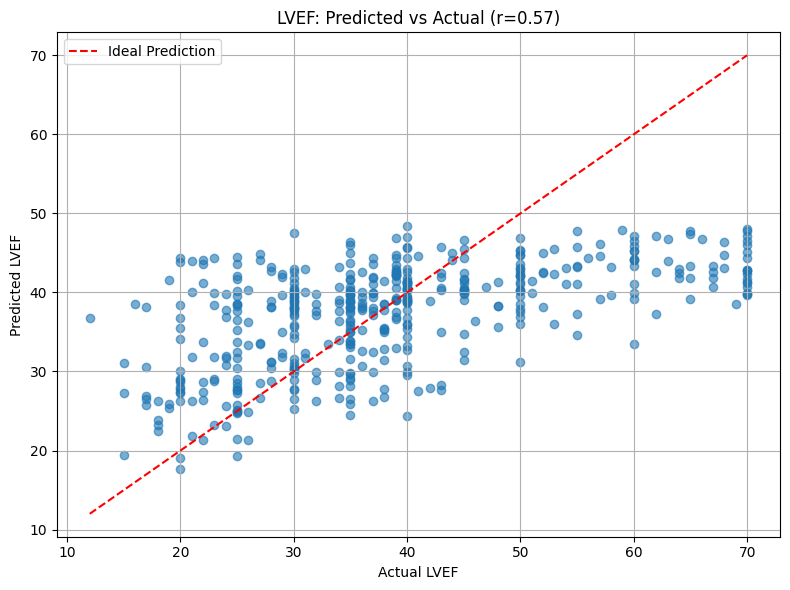

In [2]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import datetime
# No need to import train_test_split if we are not splitting for inference

# Configuration
SAMPLING_RATE = 1000
SECONDS = 5
SIGNAL_LENGTH = SAMPLING_RATE * SECONDS
TFRECORD_DIR = "./data_preparation/tfrecords-5seconds-singlelead-highres"

# Base directory for loading trained models and saving inference results
TRAINING_BASE_DIR = "./training"
INFERENCE_OUTPUT_DIR = "./inference_results"

# --- Add this configuration to specify the model type for inference ---
MODEL_TYPE = "lstm" # Change to "gru" if you want to infer with a GRU model


# Function to load a single TFRecord file and extract the signal
def load_single_tfrecord(tfrecord_file):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)

    def _parse_function(example_proto):
        feature_description = {
            'signal': tf.io.FixedLenFeature((SIGNAL_LENGTH,), tf.float32),
            'lvef': tf.io.FixedLenFeature((1,), tf.float32),
        }
        parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        signal = parsed_features['signal']
        lvef = parsed_features['lvef'][0]

        # Normalize the signal per-signal, consistent with training
        mean = tf.reduce_mean(signal)
        std = tf.math.reduce_std(signal)
        normalized_signal = (signal - mean) / (std + 1e-8)

        return normalized_signal, lvef

    parsed_dataset = raw_dataset.map(_parse_function)
    # Take the first (and should be only) example
    for signal, lvef in parsed_dataset.take(1):
        return signal.numpy(), lvef.numpy()


def perform_inference(tfrecord_files, model_lvef):
    """
    Performs inference on a set of TFRecord files using the provided LVEF model.

    Args:
        tfrecord_files (list): A list of paths to the TFRecord files.
        model_lvef (tf.keras.Model): The trained model for LVEF prediction.

    Returns:
        pandas.DataFrame: A DataFrame containing the Patient IDs, predicted LVEF, and actual LVEF.
    """
    predictions = {}
    actual_lvefs = {}

    for tfrecord_file in tqdm(tfrecord_files, desc="Predicting"):
        patient_id = os.path.splitext(os.path.basename(tfrecord_file))[0].split('_')[0]
        signal, actual_lvef = load_single_tfrecord(tfrecord_file)
        signal = np.expand_dims(signal, axis=0)

        predicted_lvef = model_lvef.predict(signal, verbose=0)[0][0]
        predictions[patient_id] = {'LVEF': predicted_lvef}
        actual_lvefs[patient_id] = actual_lvef

    results_df = pd.DataFrame.from_dict(
        {
            'Patient_ID': list(predictions.keys()),
            'Predicted_LVEF': [predictions[pid]['LVEF'] for pid in predictions],
            'Actual_LVEF': [actual_lvefs[pid] for pid in predictions.keys()],
        }
    )
    return results_df


def find_latest_model_path(base_dir, model_target_type, model_architecture_type):
    """
    Finds the path to the latest trained model directory for a given target type
    and architecture type (GRU/LSTM).
    Assumes directories are named with a timestamp prefix
    (e.g., 'YYYYMMDD_HHMMSS_lvef_independent_cnn_gru_batch8_5sec_singlelead_highres').
    """
    latest_dir = None
    latest_timestamp = None

    search_string = f"lvef_independent_cnn_{model_architecture_type}"

    for entry in os.listdir(base_dir):
        # Ensure the directory contains the target type and the specified architecture
        if model_target_type in entry and search_string in entry and os.path.isdir(os.path.join(base_dir, entry)):
            try:
                timestamp_str = entry.split('_')[0] + '_' + entry.split('_')[1]
                current_timestamp = datetime.datetime.strptime(timestamp_str, "%Y%m%d_%H%M%S")
                if latest_timestamp is None or current_timestamp > latest_timestamp:
                    latest_timestamp = current_timestamp
                    latest_dir = entry
            except (ValueError, IndexError):
                continue

    if latest_dir:
        return os.path.join(base_dir, latest_dir)
    return None


def main():
    """Main function to load models, perform inference, and calculate Pearson correlation."""
    # Create a timestamped directory for this inference run
    timestamp_inference = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    current_inference_output_dir = os.path.join(INFERENCE_OUTPUT_DIR, f"inference_run_{timestamp_inference}_{MODEL_TYPE}") # Added MODEL_TYPE to output dir
    os.makedirs(current_inference_output_dir, exist_ok=True)
    print(f"Inference results will be saved to: {current_inference_output_dir}")

    # Dynamically set the model description part based on MODEL_TYPE
    try:
        _ = BATCH_SIZE
    except NameError:
        print("WARNING: BATCH_SIZE not defined. Proceeding without it in model description string.")
        lvef_model_description_part = f"lvef_independent_cnn_{MODEL_TYPE}_{SECONDS}sec_singlelead_highres"
    else:
        lvef_model_description_part = f"lvef_independent_cnn_{MODEL_TYPE}_batch{BATCH_SIZE}_{SECONDS}sec_singlelead_highres"


    # Pass MODEL_TYPE to find_latest_model_path
    lvef_model_base_path = find_latest_model_path(TRAINING_BASE_DIR, "lvef", MODEL_TYPE)

    if not lvef_model_base_path:
        print(f"Error: Could not find the latest trained LVEF model directory for {MODEL_TYPE} in {TRAINING_BASE_DIR}")
        return

    # Dynamically set the .h5 model file name
    lvef_model_path = os.path.join(lvef_model_base_path, f"ecg_model_cnn_{MODEL_TYPE}_lvef.h5")


    # --- Load ALL TFRecord files for inference ---
    # List all TFRecord files in the directory
    all_tfrecords = [
        os.path.join(TFRECORD_DIR, f)
        for f in os.listdir(TFRECORD_DIR)
        if f.endswith(".tfrecord") and "_lead_0_window_5s_5s.tfrecord" in f # Ensure we only get the relevant files
    ]

    if not all_tfrecords:
        print(f"No TFRecord files found in {TFRECORD_DIR}. Please check your data directory.")
        return
    
    print(f"Number of TFRecord files found for inference: {len(all_tfrecords)}")


    # Load the trained model
    try:
        # Custom objects are crucial for LeakyReLU when loading the model
        model_lvef = tf.keras.models.load_model(lvef_model_path, custom_objects={'LeakyReLU': tf.keras.layers.LeakyReLU})
        print(f"Successfully loaded LVEF model ({MODEL_TYPE}) from: {lvef_model_path}")
    except Exception as e:
        print(f"Error loading model. Make sure the model exists at the specified path and handle custom objects if any: {e}")
        print(f"Attempted LVEF model path: {lvef_model_path}")
        return

    # Perform inference on ALL signals
    results_df = perform_inference(all_tfrecords, model_lvef)

    # Calculate and print MAE for LVEF
    mae_lvef = np.mean(np.abs(results_df['Predicted_LVEF'] - results_df['Actual_LVEF']))
    
    # Calculate and print MSE for LVEF
    mse_lvef = np.mean((results_df['Predicted_LVEF'] - results_df['Actual_LVEF'])**2)


    # Calculate Pearson Correlation Coefficient
    lvef_correlation, _ = pearsonr(results_df['Predicted_LVEF'], results_df['Actual_LVEF'])

    # Print results
    print("\nInference Results Summary (All Signals):")
    print(f"LVEF MAE: {mae_lvef:.4f}, MSE: {mse_lvef:.4f}, Correlation: {lvef_correlation:.4f}")

    # Save the detailed results to a CSV file.
    results_csv_path = os.path.join(current_inference_output_dir, "inference_results_all_signals.csv")
    results_df.to_csv(results_csv_path, index=False)
    print(f"Detailed inference results saved to: {results_csv_path}")

    # Create scatter plots
    plt.figure(figsize=(8, 6))

    plt.scatter(results_df['Actual_LVEF'], results_df['Predicted_LVEF'], alpha=0.6)
    plt.title(f"LVEF: Predicted vs Actual (r={lvef_correlation:.2f})")
    plt.xlabel("Actual LVEF")
    plt.ylabel("Predicted LVEF")
    plt.grid(True)
    # Add a line for ideal prediction (y=x)
    min_val = min(results_df['Actual_LVEF'].min(), results_df['Predicted_LVEF'].min())
    max_val = max(results_df['Actual_LVEF'].max(), results_df['Predicted_LVEF'].max())
    plt.plot([min_val, max_val], [min_val, max_val], '--r', label='Ideal Prediction')
    plt.legend()

    plt.tight_layout()
    plots_path = os.path.join(current_inference_output_dir, "lvef_prediction_scatter_plot_all_signals.png")
    plt.savefig(plots_path)
    print(f"Scatter plot saved to: {plots_path}")
    plt.show()


if __name__ == "__main__":
    main()

# CNN-GRU But Only For LVEF ranging 25-50

Inference results will be saved to: ./inference_results\inference_run_20250604_153801
Number of testing IDs: 139
Successfully loaded LVEF model from: ./training\20250604_151603_lvef_independent_cnn_gru_batch8_5sec_singlelead_highres\ecg_model_cnn_gru_lvef.h5


Predicting: 100%|██████████| 95/95 [00:07<00:00, 13.37it/s]



Inference Results Summary (LVEF 25-50 only):
Patients included: 62
LVEF MAE: 7.2185, MSE: 78.6813, Correlation: 0.1029
Results saved to: ./inference_results\inference_run_20250604_153801\inference_results_lvef_25-50.csv
Scatter plot saved to: ./inference_results\inference_run_20250604_153801\lvef_prediction_25-50_scatter.png


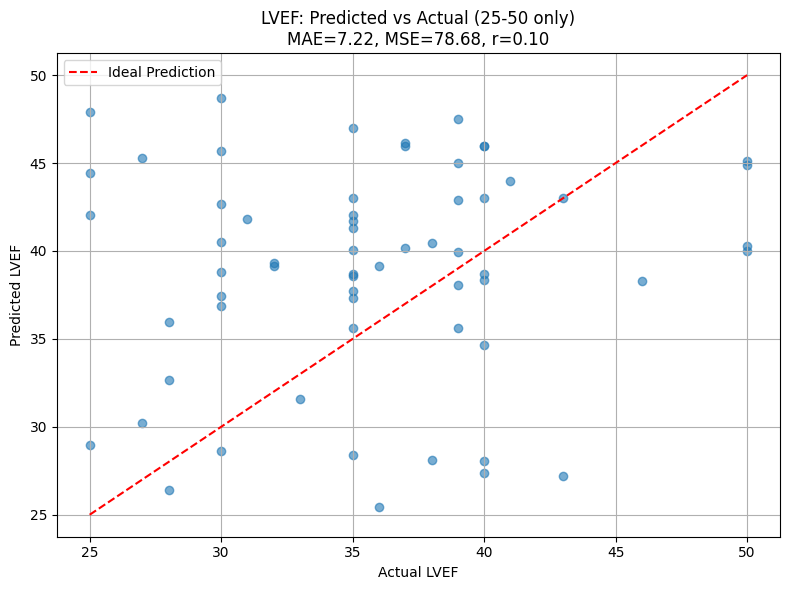

In [24]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split

# Configuration
SAMPLING_RATE = 1000
SECONDS = 5
SIGNAL_LENGTH = SAMPLING_RATE * SECONDS
TFRECORD_DIR = "./data_preparation/tfrecords-5seconds-singlelead-highres"

# Base directory for loading trained models and saving inference results
TRAINING_BASE_DIR = "./training"
INFERENCE_OUTPUT_DIR = "./inference_results"

def load_single_tfrecord(tfrecord_file):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)

    def _parse_function(example_proto):
        feature_description = {
            'signal': tf.io.FixedLenFeature((SIGNAL_LENGTH,), tf.float32),
            'lvef': tf.io.FixedLenFeature((1,), tf.float32),
        }
        parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        signal = parsed_features['signal']
        lvef = parsed_features['lvef'][0]

        # Normalize the signal per-signal, consistent with training
        mean = tf.reduce_mean(signal)
        std = tf.math.reduce_std(signal)
        normalized_signal = (signal - mean) / (std + 1e-8)

        return normalized_signal, lvef

    parsed_dataset = raw_dataset.map(_parse_function)
    for signal, lvef in parsed_dataset.take(1):
        return signal.numpy(), lvef.numpy()

def perform_inference(tfrecord_files, model_lvef, lvef_range=(25, 50)):
    """
    Performs inference on a set of TFRecord files using the provided LVEF model.
    Only includes patients with actual LVEF within the specified range.

    Args:
        tfrecord_files (list): A list of paths to the TFRecord files.
        model_lvef (tf.keras.Model): The trained model for LVEF prediction.
        lvef_range (tuple): (min, max) LVEF range to include (inclusive).

    Returns:
        pandas.DataFrame: A DataFrame containing the Patient IDs, predicted LVEF, and actual LVEF.
    """
    predictions = {}
    actual_lvefs = {}

    for tfrecord_file in tqdm(tfrecord_files, desc="Predicting"):
        patient_id = os.path.splitext(os.path.basename(tfrecord_file))[0].split('_')[0]
        signal, actual_lvef = load_single_tfrecord(tfrecord_file)
        
        # Only process if LVEF is within the desired range
        if lvef_range[0] <= actual_lvef <= lvef_range[1]:
            signal = np.expand_dims(signal, axis=0)
            predicted_lvef = model_lvef.predict(signal, verbose=0)[0][0]
            predictions[patient_id] = {'LVEF': predicted_lvef}
            actual_lvefs[patient_id] = actual_lvef

    results_df = pd.DataFrame.from_dict(
        {
            'Patient_ID': list(predictions.keys()),
            'Predicted_LVEF': [predictions[pid]['LVEF'] for pid in predictions],
            'Actual_LVEF': [actual_lvefs[pid] for pid in predictions.keys()],
        }
    )
    return results_df

def find_latest_model_path(base_dir, model_target_type):
    latest_dir = None
    latest_timestamp = None

    for entry in os.listdir(base_dir):
        if model_target_type in entry and os.path.isdir(os.path.join(base_dir, entry)):
            try:
                timestamp_str = entry.split('_')[0] + '_' + entry.split('_')[1]
                current_timestamp = datetime.datetime.strptime(timestamp_str, "%Y%m%d_%H%M%S")
                if latest_timestamp is None or current_timestamp > latest_timestamp:
                    latest_timestamp = current_timestamp
                    latest_dir = entry
            except (ValueError, IndexError):
                continue

    if latest_dir:
        return os.path.join(base_dir, latest_dir)
    return None

def main():
    timestamp_inference = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    current_inference_output_dir = os.path.join(INFERENCE_OUTPUT_DIR, f"inference_run_{timestamp_inference}")
    os.makedirs(current_inference_output_dir, exist_ok=True)
    print(f"Inference results will be saved to: {current_inference_output_dir}")

    try:
        _ = BATCH_SIZE
    except NameError:
        print("WARNING: BATCH_SIZE not defined. Proceeding without it in model description string.")
        lvef_model_description_part = f"lvef_independent_cnn_gru_{SECONDS}sec_singlelead_highres"
    else:
        lvef_model_description_part = f"lvef_independent_cnn_gru_batch{BATCH_SIZE}_{SECONDS}sec_singlelead_highres"

    lvef_model_base_path = find_latest_model_path(TRAINING_BASE_DIR, lvef_model_description_part)

    if not lvef_model_base_path:
        print(f"Error: Could not find the latest trained LVEF model directory in {TRAINING_BASE_DIR}")
        return

    lvef_model_path = os.path.join(lvef_model_base_path, "ecg_model_cnn_gru_lvef.h5")

    # Load patient data
    refTable = pd.read_csv('resources/reference-table.csv')
    all_patients = refTable['Patient_ID'].tolist()

    excluded_patients = []
    filtered_patients = [pid for pid in all_patients if pid not in excluded_patients]

    # Replicate the exact split used during training
    _, test_ids = train_test_split(filtered_patients, test_size=0.2, random_state=42)
    print(f"Number of testing IDs: {len(test_ids)}")

    # Create TFRecord file list
    inference_tfrecords = [
        os.path.join(TFRECORD_DIR, f"{pid}_lead_0_window_5s_5s.tfrecord")
        for pid in test_ids
        if os.path.exists(os.path.join(TFRECORD_DIR, f"{pid}_lead_0_window_5s_5s.tfrecord"))
    ]

    if not inference_tfrecords:
        print(f"No TFRecord files found for the test set IDs in {TFRECORD_DIR}.")
        return

    # Load the trained model
    try:
        model_lvef = tf.keras.models.load_model(lvef_model_path)
        print(f"Successfully loaded LVEF model from: {lvef_model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # Perform inference only for LVEF between 25 and 50
    results_df = perform_inference(inference_tfrecords, model_lvef, lvef_range=(25, 50))
    
    if results_df.empty:
        print("No patients found with LVEF between 25 and 50 in the test set.")
        return

    # Calculate metrics
    mae_lvef = np.mean(np.abs(results_df['Predicted_LVEF'] - results_df['Actual_LVEF']))
    mse_lvef = np.mean((results_df['Predicted_LVEF'] - results_df['Actual_LVEF'])**2)
    lvef_correlation, _ = pearsonr(results_df['Predicted_LVEF'], results_df['Actual_LVEF'])

    # Print results
    print("\nInference Results Summary (LVEF 25-50 only):")
    print(f"Patients included: {len(results_df)}")
    print(f"LVEF MAE: {mae_lvef:.4f}, MSE: {mse_lvef:.4f}, Correlation: {lvef_correlation:.4f}")

    # Save results
    results_csv_path = os.path.join(current_inference_output_dir, "inference_results_lvef_25-50.csv")
    results_df.to_csv(results_csv_path, index=False)
    print(f"Results saved to: {results_csv_path}")

    # Create scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(results_df['Actual_LVEF'], results_df['Predicted_LVEF'], alpha=0.6)
    plt.title(f"LVEF: Predicted vs Actual (25-50 only)\nMAE={mae_lvef:.2f}, MSE={mse_lvef:.2f}, r={lvef_correlation:.2f}")
    plt.xlabel("Actual LVEF")
    plt.ylabel("Predicted LVEF")
    plt.grid(True)
    plt.plot([25, 50], [25, 50], '--r', label='Ideal Prediction')
    plt.legend()
    plt.tight_layout()
    
    plots_path = os.path.join(current_inference_output_dir, "lvef_prediction_25-50_scatter.png")
    plt.savefig(plots_path)
    print(f"Scatter plot saved to: {plots_path}")
    plt.show()

if __name__ == "__main__":
    main()

Inference results will be saved to: ./inference_results\inference_run_20250604_154137
Number of TFRecord files found for inference: 457
Successfully loaded LVEF model from: ./training\20250604_151603_lvef_independent_cnn_gru_batch8_5sec_singlelead_highres\ecg_model_cnn_gru_lvef.h5


Predicting and Filtering: 100%|██████████| 457/457 [00:31<00:00, 14.67it/s]


Skipped 140 TFRecord files due to LVEF outside the 25-50 range.

Inference Results Summary (Signals with Actual LVEF between 25-50):
LVEF MAE: 6.0025, MSE: 55.8517, Correlation: 0.4117
Detailed inference results saved to: ./inference_results\inference_run_20250604_154137\inference_results_lvef_25-50.csv
Scatter plot saved to: ./inference_results\inference_run_20250604_154137\lvef_prediction_scatter_plot_lvef_25-50.png


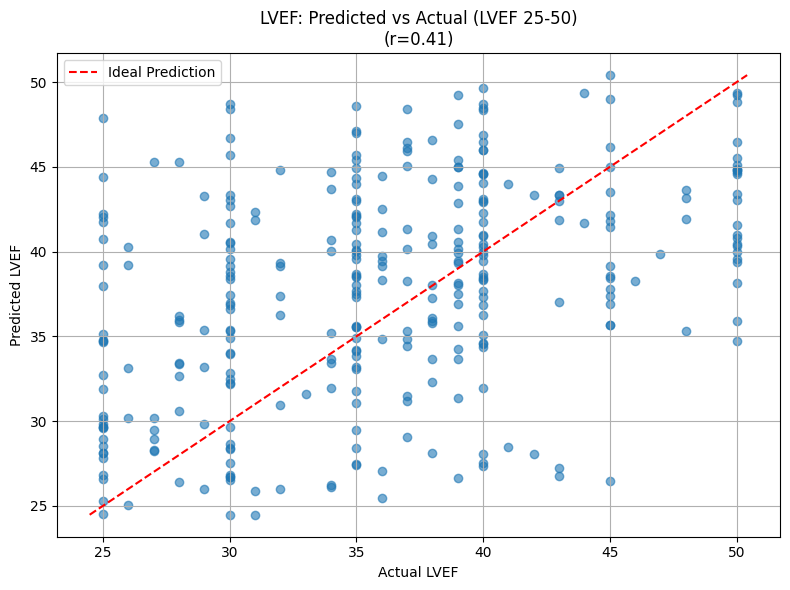

In [25]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import datetime
# No need to import train_test_split if we are not splitting for inference

# Configuration
SAMPLING_RATE = 1000
SECONDS = 5
SIGNAL_LENGTH = SAMPLING_RATE * SECONDS
TFRECORD_DIR = "./data_preparation/tfrecords-5seconds-singlelead-highres"

# Base directory for loading trained models and saving inference results
TRAINING_BASE_DIR = "./training"
INFERENCE_OUTPUT_DIR = "./inference_results"

# Define the LVEF range for inference
LVEF_INFERENCE_MIN = 25
LVEF_INFERENCE_MAX = 50


# Function to load a single TFRecord file and extract the signal
def load_single_tfrecord(tfrecord_file):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)

    def _parse_function(example_proto):
        feature_description = {
            'signal': tf.io.FixedLenFeature((SIGNAL_LENGTH,), tf.float32),
            'lvef': tf.io.FixedLenFeature((1,), tf.float32),
        }
        parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        signal = parsed_features['signal']
        lvef = parsed_features['lvef'][0]

        # Normalize the signal per-signal, consistent with training
        mean = tf.reduce_mean(signal)
        std = tf.math.reduce_std(signal)
        normalized_signal = (signal - mean) / (std + 1e-8)

        return normalized_signal, lvef

    parsed_dataset = raw_dataset.map(_parse_function)
    # Take the first (and should be only) example
    for signal, lvef in parsed_dataset.take(1):
        return signal.numpy(), lvef.numpy()


def perform_inference(tfrecord_files, model_lvef, lvef_min, lvef_max):
    """
    Performs inference on a set of TFRecord files using the provided LVEF model,
    only for signals where the actual LVEF is within the specified range.

    Args:
        tfrecord_files (list): A list of paths to the TFRecord files.
        model_lvef (tf.keras.Model): The trained model for LVEF prediction.
        lvef_min (float): The minimum LVEF value for inference.
        lvef_max (float): The maximum LVEF value for inference.

    Returns:
        pandas.DataFrame: A DataFrame containing the Patient IDs, predicted LVEF, and actual LVEF
                          for the filtered signals.
    """
    predictions = {}
    actual_lvefs = {}
    filtered_count = 0

    for tfrecord_file in tqdm(tfrecord_files, desc="Predicting and Filtering"):
        patient_id = os.path.splitext(os.path.basename(tfrecord_file))[0].split('_')[0]
        signal, actual_lvef = load_single_tfrecord(tfrecord_file)

        # Only proceed with inference if actual_lvef is within the desired range
        if lvef_min <= actual_lvef <= lvef_max:
            signal = np.expand_dims(signal, axis=0)
            predicted_lvef = model_lvef.predict(signal, verbose=0)[0][0]
            predictions[patient_id] = {'LVEF': predicted_lvef}
            actual_lvefs[patient_id] = actual_lvef
        else:
            filtered_count += 1

    print(f"Skipped {filtered_count} TFRecord files due to LVEF outside the {lvef_min}-{lvef_max} range.")

    results_df = pd.DataFrame.from_dict(
        {
            'Patient_ID': list(predictions.keys()),
            'Predicted_LVEF': [predictions[pid]['LVEF'] for pid in predictions],
            'Actual_LVEF': [actual_lvefs[pid] for pid in predictions.keys()],
        }
    )
    return results_df


def find_latest_model_path(base_dir, model_target_type):
    """
    Finds the path to the latest trained model directory for a given target type.
    Assumes directories are named with a timestamp prefix (e.g., 'YYYYMMDD_HHMMSS_lvef_model_description').
    """
    latest_dir = None
    latest_timestamp = None

    for entry in os.listdir(base_dir):
        if model_target_type in entry and os.path.isdir(os.path.join(base_dir, entry)):
            try:
                timestamp_str = entry.split('_')[0] + '_' + entry.split('_')[1]
                current_timestamp = datetime.datetime.strptime(timestamp_str, "%Y%m%d_%H%M%S")
                if latest_timestamp is None or current_timestamp > latest_timestamp:
                    latest_timestamp = current_timestamp
                    latest_dir = entry
            except (ValueError, IndexError):
                continue

    if latest_dir:
        return os.path.join(base_dir, latest_dir)
    return None


def main():
    """Main function to load models, perform inference, and calculate Pearson correlation."""
    # Create a timestamped directory for this inference run
    timestamp_inference = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    current_inference_output_dir = os.path.join(INFERENCE_OUTPUT_DIR, f"inference_run_{timestamp_inference}")
    os.makedirs(current_inference_output_dir, exist_ok=True)
    print(f"Inference results will be saved to: {current_inference_output_dir}")

    try:
        _ = BATCH_SIZE
    except NameError:
        print("WARNING: BATCH_SIZE not defined. Proceeding without it in model description string.")
        lvef_model_description_part = f"lvef_independent_cnn_gru_{SECONDS}sec_singlelead_highres"
    else:
        lvef_model_description_part = f"lvef_independent_cnn_gru_batch{BATCH_SIZE}_{SECONDS}sec_singlelead_highres"


    lvef_model_base_path = find_latest_model_path(TRAINING_BASE_DIR, lvef_model_description_part)

    if not lvef_model_base_path:
        print(f"Error: Could not find the latest trained LVEF model directory in {TRAINING_BASE_DIR}")
        return

    lvef_model_path = os.path.join(lvef_model_base_path, "ecg_model_cnn_gru_lvef.h5")

    # --- Load ALL TFRecord files for inference ---
    # List all TFRecord files in the directory
    all_tfrecords = [
        os.path.join(TFRECORD_DIR, f)
        for f in os.listdir(TFRECORD_DIR)
        if f.endswith(".tfrecord") and "_lead_0_window_5s_5s.tfrecord" in f # Ensure we only get the relevant files
    ]

    if not all_tfrecords:
        print(f"No TFRecord files found in {TFRECORD_DIR}. Please check your data directory.")
        return
    
    print(f"Number of TFRecord files found for inference: {len(all_tfrecords)}")


    # Load the trained model
    try:
        # Custom objects might be needed if you used custom layers or activations (e.g., Leaky ReLU)
        # model_lvef = tf.keras.models.load_model(lvef_model_path, custom_objects={'LeakyReLU': tf.keras.layers.LeakyReLU})
        model_lvef = tf.keras.models.load_model(lvef_model_path)
        print(f"Successfully loaded LVEF model from: {lvef_model_path}")
    except Exception as e:
        print(f"Error loading model. Make sure the model exists at the specified path and handle custom objects if any: {e}")
        print(f"Attempted LVEF model path: {lvef_model_path}")
        return

    # Perform inference, now with LVEF filtering
    results_df = perform_inference(all_tfrecords, model_lvef, LVEF_INFERENCE_MIN, LVEF_INFERENCE_MAX)

    if results_df.empty:
        print(f"No signals found with Actual LVEF between {LVEF_INFERENCE_MIN} and {LVEF_INFERENCE_MAX}. No further analysis performed.")
        return

    # Calculate and print MAE and MSE for LVEF
    mae_lvef = np.mean(np.abs(results_df['Predicted_LVEF'] - results_df['Actual_LVEF']))
    mse_lvef = np.mean((results_df['Predicted_LVEF'] - results_df['Actual_LVEF'])**2)

    # Calculate Pearson Correlation Coefficient
    lvef_correlation, _ = pearsonr(results_df['Predicted_LVEF'], results_df['Actual_LVEF'])

    # Print results
    print(f"\nInference Results Summary (Signals with Actual LVEF between {LVEF_INFERENCE_MIN}-{LVEF_INFERENCE_MAX}):")
    print(f"LVEF MAE: {mae_lvef:.4f}, MSE: {mse_lvef:.4f}, Correlation: {lvef_correlation:.4f}")

    # Save the detailed results to a CSV file.
    results_csv_path = os.path.join(current_inference_output_dir, f"inference_results_lvef_{LVEF_INFERENCE_MIN}-{LVEF_INFERENCE_MAX}.csv")
    results_df.to_csv(results_csv_path, index=False)
    print(f"Detailed inference results saved to: {results_csv_path}")

    # Create scatter plots
    plt.figure(figsize=(8, 6))

    plt.scatter(results_df['Actual_LVEF'], results_df['Predicted_LVEF'], alpha=0.6)
    plt.title(f"LVEF: Predicted vs Actual (LVEF {LVEF_INFERENCE_MIN}-{LVEF_INFERENCE_MAX})\n(r={lvef_correlation:.2f})")
    plt.xlabel("Actual LVEF")
    plt.ylabel("Predicted LVEF")
    plt.grid(True)
    # Add a line for ideal prediction (y=x)
    min_val = min(results_df['Actual_LVEF'].min(), results_df['Predicted_LVEF'].min())
    max_val = max(results_df['Actual_LVEF'].max(), results_df['Predicted_LVEF'].max())
    plt.plot([min_val, max_val], [min_val, max_val], '--r', label='Ideal Prediction')
    plt.legend()

    plt.tight_layout()
    plots_path = os.path.join(current_inference_output_dir, f"lvef_prediction_scatter_plot_lvef_{LVEF_INFERENCE_MIN}-{LVEF_INFERENCE_MAX}.png")
    plt.savefig(plots_path)
    print(f"Scatter plot saved to: {plots_path}")
    plt.show()


if __name__ == "__main__":
    main()